In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from scipy.special import gamma
from scipy.stats import norm

import jax
import jax.numpy as jnp 
import jax.random as jrandom

from jax_optimization import run_jit_rdp_final, run_jit_gauss_final, Logistic_Loss

/tmp/ipykernel_2885014/1602125146.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def import_dataset(path):
    def load_csv(path):
        df = pd.read_csv(path)
        return np.array(df.loc[:,df.columns != "target"]), np.array(df["target"])

    X_raw, y_raw = load_csv(path + "_raw.csv")
    X_norm, y_norm = load_csv(path + "_norm.csv")

    return X_raw, y_raw, X_norm, y_norm

def get_RDP_stuff(filename):

    with open(filename, 'rb') as f:
        loaded_parameters = pickle.load(f)
        rho = float(loaded_parameters["Our_RD"])
        noise_parameters = loaded_parameters["noise_parameters"]
        if isinstance(noise_parameters, list):
            noise_parameters = jnp.array(noise_parameters)
    return noise_parameters, rho


def get_sigma_from_cost(cost, q):
    sigma_to_power_q_times_two_to_power_q_ov_2 = cost * np.sqrt(np.pi) / gamma( (q+1)/ 2 )
    return (sigma_to_power_q_times_two_to_power_q_ov_2)**(1/q) / np.sqrt(2)

def get_sigma_from_privacy(beta, rho):
    #rho = beta  / 2 / sigma_gaussian^2
    return np.sqrt(beta / 2 / rho)

data_dir = "Datasets/"
X_electricity_raw, y_electricity_raw, X_electricity_norm, y_electricity_norm = import_dataset(data_dir + "electricity/data/electricity")

In [3]:

#initialize
data = (X_electricity_norm, y_electricity_norm)
num_features = data[0].shape[1]
q = 8 # this is power of the cost function, i.e. C(x) = x^q
Cost = 1000.2372012565252
k = 40 # 1/k is number of bins
N = 1000
r = 0.99
beta = 2

print(f"Number of bins used by the RDP optimization is {N}")
print(f"Size of each bin is {1/k}")
print(f"Range of the RDP optimization is (-{int(N/k)}, {int(N/k)})")

filename = f"RDP_Mechanisms/noise_k{k}_N{N}_r{r}_cost{Cost}_q{q}_beta{2}.pkl"
rdp_noise_params, rho = get_RDP_stuff(filename) #grab the noise parameters and rho, i.e. Renyi Divergence
rdp_sigma = get_sigma_from_cost(Cost, q) #return the sigma of a mean-0 Gaussian RV X s.t. E[X^q] = Cost

gaussian_sigma = get_sigma_from_privacy(beta, rho) #return sigma of Gaussian mechanism s.t. it is (beta,rho)-RDP
print(f"Effective sigma of RDP noise is {rdp_sigma:0.4}") 
print(f"sigma used for Gaussian noise is {gaussian_sigma:0.4}") 

#initialize for Jax code
#feel free to vary epochs, clip, learningraye, and hyperparams_prox
gaussian_sigma_array = jnp.array([gaussian_sigma] * num_features) #the number of features in X
seed = 42
epochs = 10
hyperparams_prox = 1.0 / X_electricity_raw.shape[0] #L2 regularization parameter. Taken from C++ code
w_init = jnp.zeros(num_features)
clip = 4.328761281083061
learning_rate = 2.154434690031882

Loss = Logistic_Loss(data, hyperparams_prox)

Number of bins used by the RDP optimization is 1000
Size of each bin is 0.025
Range of the RDP optimization is (-25, 25)
Effective sigma of RDP noise is 1.325
sigma used for Gaussian noise is 1.331


In [4]:
w_rdp, rdp_obj_per_epoch = run_jit_rdp_final(Loss, w_init, clip, \
            rdp_noise_params, learning_rate, epochs, seed, k)

In [5]:
w_gauss, gauss_obj_per_epoch = run_jit_gauss_final(Loss, w_init, clip, \
            gaussian_sigma_array, learning_rate, epochs, seed)

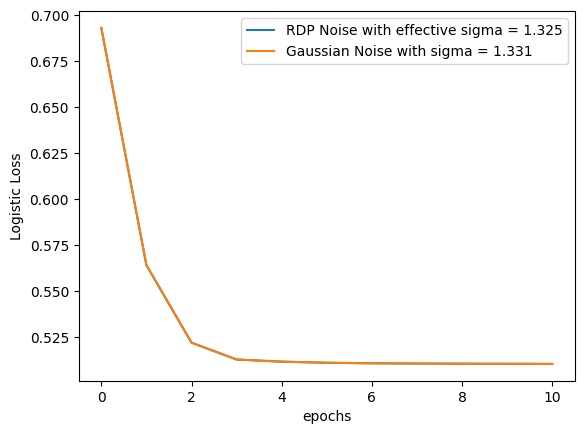

In [6]:
epochs_array = np.arange(epochs+1)
plt.plot(epochs_array, rdp_obj_per_epoch, label = f'RDP Noise with effective sigma = {rdp_sigma:0.4}')
plt.plot(epochs_array, gauss_obj_per_epoch, label = f'Gaussian Noise with sigma = {gaussian_sigma:0.4}')
plt.legend(); plt.xlabel("epochs"); plt.ylabel("Logistic Loss");